# 使用网络科学进行收视率分析

# 电视收视率
某一时段内收看某电视频道（或某电视节目）的人数（或家户数）占电视观众总人数（或家户数）的百分比。作为“注意力经济”时代的重要量化指标，它是深入分析电视收视市场的科学基础，是节目制作、编排及调整的重要参考，是节目评估的主要指标，是制定与评估媒介计划、提高广告投放效益的有力工具。

收视率计算就是用户总收视时长/该时段总时长*总用户数 

In [247]:
%matplotlib inline

import pandas as pd
import re
import sys
import random
import numpy as np
import datetime
from numpy import delete
from numpy import linalg as LA
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import networkx as nx
import statsmodels.api as sm
from collections import Counter, defaultdict
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  

In [119]:
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()

## 读入数据

In [54]:
raw_df = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/yangzhouTvAds/扬州原始数据11.18-12.18/20151118.txt', 
                     delimiter='|', encoding='gbk', 
                     names = ['MAC_ADDR', 'TIME', 'CHANNEL_NUM', 'CHANNEL_TYPE', 'CHANNEL_NAME', 'CHANNEL_PID',
                              'CHANNEL_VID', 'CHANNEL_AID', 'CHANNEL_VOLUME', 'CHANNEL_FREQUENCE', 'CERTIFICATE',
                              'UNKNOWN', 'UNKNOWN1'])

In [55]:
# 剔除不需要的列
raw_df.drop(raw_df.columns[range(5,13)], axis=1, inplace=True)
raw_df.drop(raw_df.columns[[2, 3]], axis=1, inplace=True)

## 选取黄金时间
黄金时间不是20：00~22：00

In [128]:
raw_df['TIME'] = pd.to_datetime(raw_df['TIME'])

start_date = datetime.datetime.strptime('2015-11-18 20:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.datetime.strptime('2015-11-18 22:00:00', '%Y-%m-%d %H:%M:%S')

mask = (raw_df['TIME'] > start_date) & (raw_df['TIME'] <= end_date)

raw_df = raw_df.loc[mask]
raw_df = raw_df.reset_index(drop=True)
#print time_df

In [129]:
raw_df['TIME'] = pd.to_datetime(raw_df['TIME'])
raw_df[:3]

,MAC_ADDR,TIME,CHANNEL_NAME
0,000e09897392,2015-11-18 21:16:43,扬州新闻
1,000e09897392,2015-11-18 21:18:35,扬州城市
2,000e09897392,2015-11-18 21:18:52,扬州江都


In [246]:
gap_df = raw_df.sort_values(["MAC_ADDR","TIME"],ascending=True)
gap_df = gap_df.reset_index(drop=True)
gap_df[:10]

,MAC_ADDR,TIME,CHANNEL_NAME
0,000e0983922f,2015-11-18 20:09:08,CCTV-1
1,000e0983922f,2015-11-18 20:09:32,CCTV-3
2,000e0983922f,2015-11-18 20:09:39,CCTV-4
3,000e0983922f,2015-11-18 20:14:43,CCTV-3
4,000e0983922f,2015-11-18 20:14:51,扬州新闻
5,000e0983922f,2015-11-18 20:14:59,CCTV-1
6,000e0983922f,2015-11-18 20:15:07,CCTV-3
7,000e0983922f,2015-11-18 20:15:15,CCTV-4
8,000e0983922f,2015-11-18 20:17:39,CCTV-3
9,000e0983922f,2015-11-18 20:17:48,CCTV-4


In [131]:
len(gap_df), len(raw_df)

(153633, 153633)

## 计算个体收看持续时间

In [132]:
import datetime
end_date = datetime.datetime.strptime('2015-11-18 23:59:59', '%Y-%m-%d %H:%M:%S')
df_length = max(gap_df.index)
gap = []
for i in gap_df.index:
    if i % 1000 == 0:
        flushPrint(i)
    if i < df_length and gap_df.iloc[i+1]['MAC_ADDR'] == gap_df.iloc[i]['MAC_ADDR'] : # 下一行还是这个人的时候执行
            time_a = gap_df.iloc[i]['TIME']
            time_b = gap_df.iloc[i+1]['TIME']
    else:
        time_a = gap_df.iloc[i]['TIME']
        time_b = end_date   
    gap.append((time_b - time_a).seconds)

gap_df['gap'] = gap


153000

## 选取收看时间大于5分钟的行为
否则属于选台时间

In [140]:
hits_df = gap_df[gap_df.gap > 300]
hits_df = hits_df[hits_df.gap < 5*60*60]
hits_df = hits_df.reset_index(drop=True)

In [143]:
gap_df[:10]

,MAC_ADDR,TIME,CHANNEL_NAME,gap
0,000e0983922f,2015-11-18 20:09:08,CCTV-1,24
1,000e0983922f,2015-11-18 20:09:32,CCTV-3,7
2,000e0983922f,2015-11-18 20:09:39,CCTV-4,304
3,000e0983922f,2015-11-18 20:14:43,CCTV-3,8
4,000e0983922f,2015-11-18 20:14:51,扬州新闻,8
5,000e0983922f,2015-11-18 20:14:59,CCTV-1,8
6,000e0983922f,2015-11-18 20:15:07,CCTV-3,8
7,000e0983922f,2015-11-18 20:15:15,CCTV-4,144
8,000e0983922f,2015-11-18 20:17:39,CCTV-3,9
9,000e0983922f,2015-11-18 20:17:48,CCTV-4,223


In [142]:
hits_df[:10]

,MAC_ADDR,TIME,CHANNEL_NAME,gap
0,000e0983922f,2015-11-18 20:09:39,CCTV-4,304
1,000e0983922f,2015-11-18 20:21:31,扬州新闻,3792
2,000e0983922f,2015-11-18 21:24:43,CCTV-2,1800
3,000e0983922f,2015-11-18 21:59:23,扬州新闻,7236
4,000e09839264,2015-11-18 20:17:15,北京卫视,13364
5,000e09839274,2015-11-18 20:49:24,扬州生活,1871
6,000e09839274,2015-11-18 21:20:51,扬州新闻,9548
7,000e09839278,2015-11-18 20:13:23,山西卫视,377
8,000e09839278,2015-11-18 20:22:19,山西卫视,2408
9,000e09839278,2015-11-18 21:02:27,CCTV-5,10652


# 计算传统收视率
- 净观看人数
- 所有人的观看时间

In [215]:
person_rating = defaultdict(int)
time_rating = defaultdict(int)

channels = set(hits_df['CHANNEL_NAME'])
for i in channels:
    di = hits_df[hits_df['CHANNEL_NAME']==i]
    time_length = np.sum(di['gap'])
    person_num = len(set(di['MAC_ADDR']))
    person_rating[i]=  person_num
    time_rating[i]=time_length

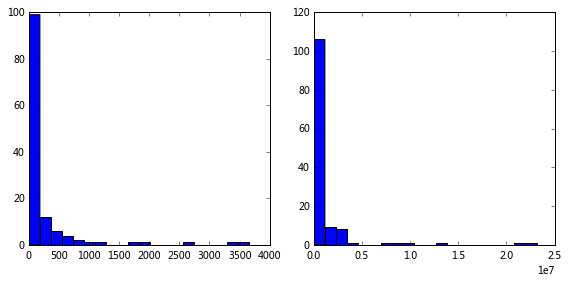

In [216]:
fig = plt.figure(figsize=(8, 4),facecolor='white')

ax = fig.add_subplot(1,2,1)
plt.hist(person_rating.values(), 20)
ax = fig.add_subplot(1,2,2)
plt.hist(time_rating.values(), 20)
plt.tight_layout()
plt.show()

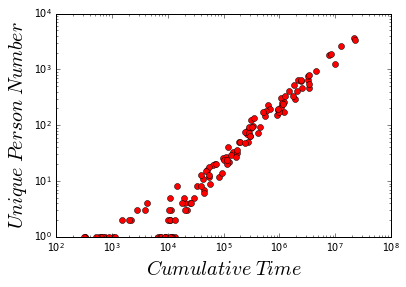

In [218]:
plt.plot(time_rating.values(), person_rating.values(), 'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Cumulative\;Time$', fontsize = 20)
plt.ylabel('$Unique\;Person\;Number$', fontsize = 20)
plt.show()

两种定义是等价的。

# 构建用户-电视节目的二模网络

In [185]:
user = gap_df[u'MAC_ADDR'].tolist()
channel = gap_df[u'CHANNEL_NAME'].tolist()

G = nx.DiGraph()
for i in gap_df.index:
    G.add_edge(user[i], channel[i])

In [186]:
h, a = nx.hits(G)

In [239]:
channel_hub = [h[i] for i in channel]
channel_authoriy = [a[i] for i in channel] # channels have only authority
channel_time = [time_rating[i]+1 for i in channel]
channel_person = [person_rating[i]+1 for i in channel]

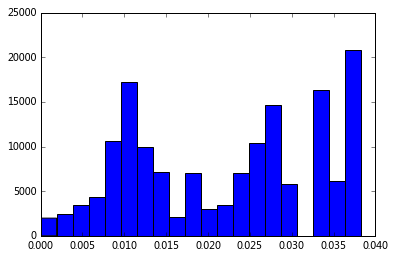

In [240]:
plt.hist(channel_authoriy, 20)
plt.show()

In [241]:
np.min(channel_authoriy), np.min(channel_person)

(1.5070401808777618e-06, 1)

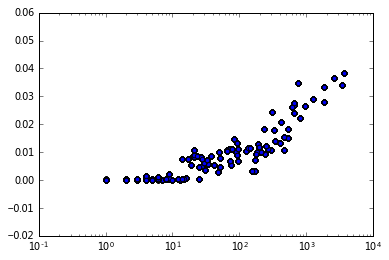

In [242]:
plt.scatter(channel_person, channel_authoriy)
plt.xscale('log')
plt.show()

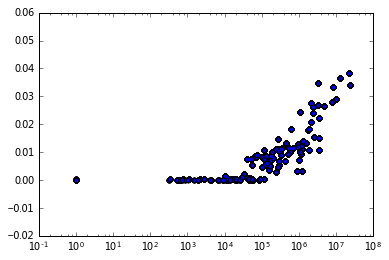

In [243]:
plt.scatter(channel_time, channel_authoriy)
plt.xscale('log')
plt.show()

In [245]:
import numpy as np
from scipy.stats.stats import pearsonr

#np.corrcoef(a, o), 
coef_t, pvalue_t = pearsonr(channel_time, channel_authoriy)#, pearsonr(h, o), pearsonr(a, h)
coef_p, pvalue_p = pearsonr(channel_person, channel_authoriy)#, pearsonr(h, o), pearsonr(a, h)

print(coef_t, pvalue_t, coef_p, pvalue_p)

(0.76741086931159119, 0.0, 0.82593953272453702, 0.0)


# END

147000

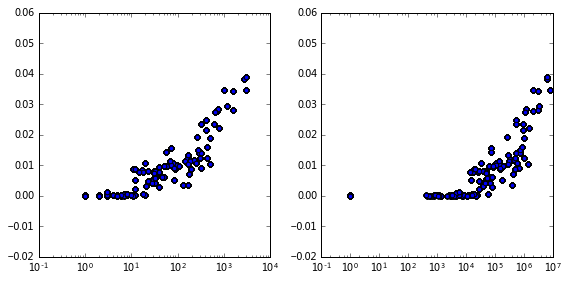

(0.81093211643225815, 0.0, 0.85835872544334846, 0.0)


In [249]:

raw_df = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/yangzhouTvAds/扬州原始数据11.18-12.18/20151119.txt', 
                     delimiter='|', encoding='gbk', 
                     names = ['MAC_ADDR', 'TIME', 'CHANNEL_NUM', 'CHANNEL_TYPE', 'CHANNEL_NAME', 'CHANNEL_PID',
                              'CHANNEL_VID', 'CHANNEL_AID', 'CHANNEL_VOLUME', 'CHANNEL_FREQUENCE', 'CERTIFICATE',
                              'UNKNOWN', 'UNKNOWN1'])
raw_df.drop(raw_df.columns[range(5,13)], axis=1, inplace=True)
raw_df.drop(raw_df.columns[[2, 3]], axis=1, inplace=True)
raw_df['TIME'] = pd.to_datetime(raw_df['TIME'])

start_date = datetime.datetime.strptime('2015-11-19 20:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.datetime.strptime('2015-11-19 22:00:00', '%Y-%m-%d %H:%M:%S')

mask = (raw_df['TIME'] > start_date) & (raw_df['TIME'] <= end_date)

raw_df = raw_df.loc[mask]
raw_df = raw_df.reset_index(drop=True)
raw_df['TIME'] = pd.to_datetime(raw_df['TIME'])

gap_df = raw_df.sort_values(["MAC_ADDR","TIME"],ascending=True)
gap_df = gap_df.reset_index(drop=True)

df_length = max(gap_df.index)
gap = []
for i in gap_df.index:
    if i % 1000 == 0:
        flushPrint(i)
    if i < df_length and gap_df.iloc[i+1]['MAC_ADDR'] == gap_df.iloc[i]['MAC_ADDR'] : # 下一行还是这个人的时候执行
            time_a = gap_df.iloc[i]['TIME']
            time_b = gap_df.iloc[i+1]['TIME']
    else:
        time_a = gap_df.iloc[i]['TIME']
        time_b = end_date   
    gap.append((time_b - time_a).seconds)

gap_df['gap'] = gap
hits_df = gap_df[gap_df.gap > 300]
hits_df = hits_df[hits_df.gap < 5*60*60]
hits_df = hits_df.reset_index(drop=True)

person_rating = defaultdict(int)
time_rating = defaultdict(int)

channels = set(hits_df['CHANNEL_NAME'])
for i in channels:
    di = hits_df[hits_df['CHANNEL_NAME']==i]
    time_length = np.sum(di['gap'])
    person_num = len(set(di['MAC_ADDR']))
    person_rating[i]=  person_num
    time_rating[i]=time_length
    
user = hits_df[u'MAC_ADDR'].tolist()
channel = hits_df[u'CHANNEL_NAME'].tolist()

G = nx.DiGraph()
for i in gap_df.index:
    G.add_edge(user[i], channel[i])

h, a = nx.hits(G)
channel_authoriy = [a[i] for i in channel] # channels have only authority
channel_time = [time_rating[i]+1 for i in channel]
channel_person = [person_rating[i]+1 for i in channel]

fig = plt.figure(figsize=(8, 4),facecolor='white')

ax = fig.add_subplot(1,2,1)
plt.scatter(channel_person, channel_authoriy)
plt.xscale('log')
ax = fig.add_subplot(1,2,2)
plt.scatter(channel_time, channel_authoriy)
plt.xscale('log')
plt.tight_layout()
plt.show()

from scipy.stats.stats import pearsonr

#np.corrcoef(a, o), 
coef_t, pvalue_t = pearsonr(channel_time, channel_authoriy)#, pearsonr(h, o), pearsonr(a, h)
coef_p, pvalue_p = pearsonr(channel_person, channel_authoriy)#, pearsonr(h, o), pearsonr(a, h)

print(coef_t, pvalue_t, coef_p, pvalue_p)